# Generating Abstract Art using a Random Weights Neural Net (Reproducing the work from Otoro.net in NumPy)

## Original work

I've recently read some articles on the [Otoro blog](http://blog.otoro.net/), and in [one of the posts](http://blog.otoro.net/2016/03/25/generating-abstract-patterns-with-tensorflow/) the author described this neural network that can generate some interesting abstract samples without any training!

The network used -- a variation of CPPN ([Compositional Pattern-Producing Networks](https://en.wikipedia.org/wiki/Compositional_pattern-producing_network)) -- has the following fundamental property: it takes as input _coordinates_  and outputs a colour for a pixel at those coordinates. That means that you can output arbitrarily large images simply by running the network on more pixel coordinates! [Otoro blog](http://blog.otoro.net/) has several excellent posts on this, and all the code is on GitHub, so please check out the blog for more discussion on this.

## Motivation

The point of this notebook is to go through implementing a very simple RPPN work using only `numpy`. The authors used `tensorflow`, and the code is very extensible, but I wanted to see for myself how exactly this works. Further, by using a notebook, one can easily clone/fork and make their own modifications easily. I will also try to explain everything that I'm doing, and comment all the code.

## How it works

The idea is simple:
- Create a deep neural network with random weights;
- Pass the input coordinates $(x,y)$ and output a pixel value;
- Do the same forward pass for however many pixels you need while storing the outputs;
- Display the output values as an image.

Notice that at no point there is any training done. It just uses the initial random weights which is still amazing to me! For simplicity, the network will be the same as the one used in the original work -- a multilayer perceptron.

## Imports

In [1]:
%matplotlib inline

# Numpy for linear algebra, numerical computations,
# sampling random numbers, activation functions, etc.
import numpy as np
# Matplotlib is only used for displaying the image
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10 # Bigger figures

## Multilayer Perceptron

### Basics

(Please feel free to skip this if you're familiar with MLPs)

The network architecture will be really simple:

Each neuron will compute the hyperbolic tangent function of the dot product between the relevant weights and the outputs of the previous layer. This may sound more complicated than it actually is:

Let's take the first hidden layer as an example, and imagine we only have 2 inputs -- the 2 coordinates: 

Each neuron $i$ in the hidden layer will be connected with the 2 inputs ($x_1$ and $x_2$) through 2 connections of different weights: $w_{i1}$ and $w_{i2}$. To compute the output of neuron $i$ we do the following: $f(x_1 w_{i1} + x_2 w_{i2})$ where $f(x)$ is called an _activation function_ and if it's nonlinear, it provides the network with some nonlinearity. Common activation functions are sigmoid, rectifier, and hyperbolic tangent ($\text{tanh}(x) = \frac{1-e^{-2x}}{1+e^{-2x}}$). I use the hyperbolic tangent mainly because `numpy` provides `np.tanh()` and that's what it was used on the Otoro blog. Note that different activation functions provide different results!

These weights are initialised randomly, and the number of weights for the first layer will be equal to 2 times the number of neurons. This carries on in the next layer, but using the outputs of the previous layer as inputs, until the very end when the output neuron calculates something like $f(x_1 w_1 + \dots + x_n w_n)$ where $x_i$ is the output of the neuron $i$ in the last hidden layer, $w_i$ is the weight associated with the connection between the output neuron and the $i$ neuron, and $n$ is the number of the neurons in the layer. If we want to output colour images, we will need 3 neurons in the output layer to output 3 colour channels (red, green, blue).

### Implementation

The implementation is very basic and is done in about **10 lines of code**, but I'll add more comments for clarification.

In [2]:
class Network():
    """Implement a basic MLP
    
    This has many limitations wrt extensibility, but it works for the
    case at hand. For instance, all layers will have the same number
    of neurons for simplicity.
    """
    def __init__(self, n_layers, n_neurons, n_inputs=2, n_outputs=1):
        """Setup the matrices/tensors (3D matrices) of weights
        
        I split the weights in 3 different data structures:
            - `input_weights` contains a matrix of weights such that
              each (input, neuron) pair corresponds to a weight.
              Programmatically, input_weights[i][j] corresponds to
              the weight between input `i` and neuron `j`.
            - `hidden_weights` is a tensor, or a vector of matrices,
              such that each matrix represents the weights connecting
              2 hidden layers (similar to above)
            - `output_weights` is the final matrix that connects the neurons
              from the last hidden layer to the output neurons.
        
        I'm only storing the weights in multiple matrices to account for different
        dimensions. Also, note that the weights don't need to be updated after
        initialisation, so we don't need to think about that at all.
        
        The other important matrix is the outputs matrix where the output
        of each neuron is updated in the forward pass, and this will be 
        futher discussed in the relevant function.
        """
        
        # All weights are sampled from a normal distribution. This actually
        # makes a difference, as sampling from a uniform distribution does not
        # produce very compelling results. Other distributions may provide
        # different results!
        self.input_weights = np.random.normal(size=(n_inputs, n_neurons))
        self.hidden_weights = np.random.normal(size=(n_layers, n_neurons, n_neurons))   
        self.output_weights = np.random.normal(size=(n_neurons, n_outputs))
        
        # For now, consider the output of all neurons to be 0
        # because nothing has been computed yet.
        self.outputs = np.zeros(shape=(n_layers, n_neurons))
        
        # Just so we know in the forward pass through how many
        # layers we need to go through.
        self.n_layer = n_layers
    
    def forward_pass(self, inputs):
        """Compute one value using the weights assigned previously
        
        After a network was initialised, we can do a forward pass and get
        our pixel value. As discussed previously, the output of each neuron
        is simply the dot product of the relevant weights and inputs passed
        through a tanh function. 
        """
        # Compute the outputs for the first hidden layer 
        self.outputs[0, :] = np.tanh(self.input_weights.T @ inputs)
        
        # Compute the outputs of the rest of the hidden layers
        for layer in range(1, self.n_layer):
            self.outputs[layer, :] = np.tanh(self.outputs[layer - 1, :] @ self.hidden_weights[layer])            
        
        # Return the final output of the output layer.
        return np.tanh(self.outputs[-1, :] @ self.output_weights)

And we're done! The network is ready, and we can now output images.

### Usage

Before creating images, let's just show how it works.

In [3]:
# Create a network with 3 hidden layers, and 12 neurons on each layer.
# By default, the number of inputs will be 2, and the number of output
# will be 1 (i.e. just intensity for greyscale images)
net = Network(3, 12)

# Now do a forward pass using (1,1) as input:
net.forward_pass([1,1])

array([-0.98497879])

Done -- that's our pixel value for position $(1,1)$ (if you're used to pixel values between 0 and 255, the displaying function will take care of normalising the values)

## Generating Images

So let's try to generate a full image by simply calling the function height x weight times and then display the image:

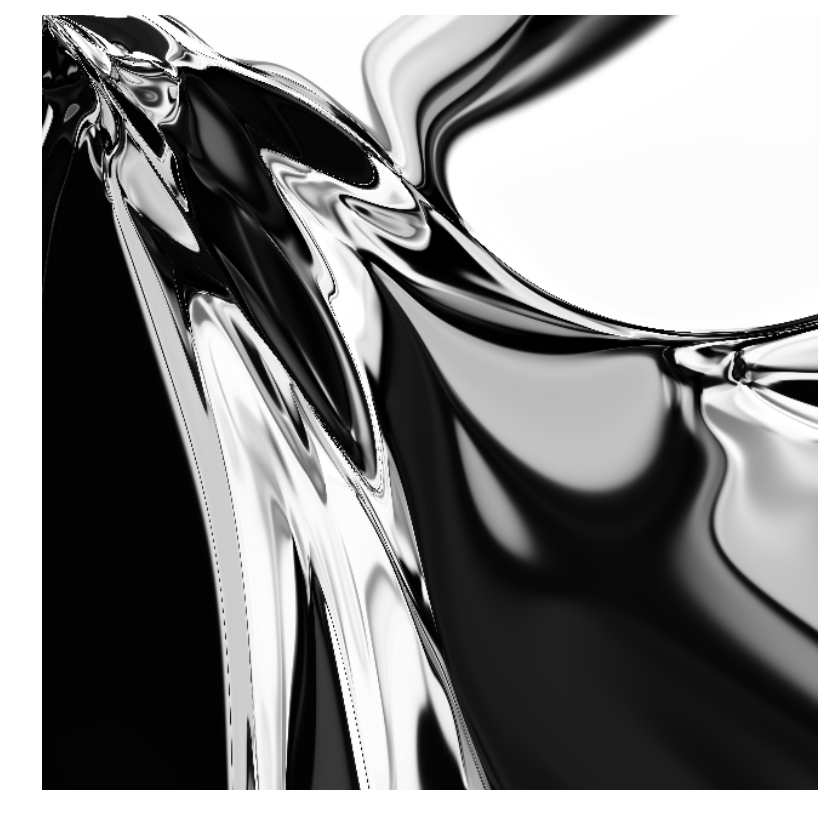

In [4]:
n_layers = 15  # Arbitrary number of layers
n_neurons = 16 # Arbitrary number of neurons
width = 640    # Not very big so it's quick, but you can set this to anything
height = 640   # Doesn't need to be square, but I'll just have it square


# Create a function so we can call it with varying arguments
def generate_image(n_layers, n_neurons, width, height, n_in=2, n_out=1):
    """Generate an image pixel by pixel"""
    net = Network(n_layers, n_neurons, n_in, n_out) # Create our network
    image = np.zeros(shape=(width, height, n_out)) # Initialise an empty image
    # Go through all pixels that we want generated
    for i in range(width):
        for j in range(height):
            # _NOTE_ that I am normalising the i, j coordinates
            # such that values between different i,j are not very big
            # given that the weights are only between 0 and 1
            image[i,j] = net.forward_pass([i/width, j/height])
    return image

# Generate our image
image = generate_image(n_layers, n_neurons, width, height) 

def show_image(image, bw=True):
    """Quick function for generating bw/colour image without axes labels"""
    plt.axis('off') # No need for axes
    plt.imshow(image[:,:,0] if bw else image, cmap='gray' if bw else None)
    
show_image(image)

Great! Let's try a colour image with other parameters.

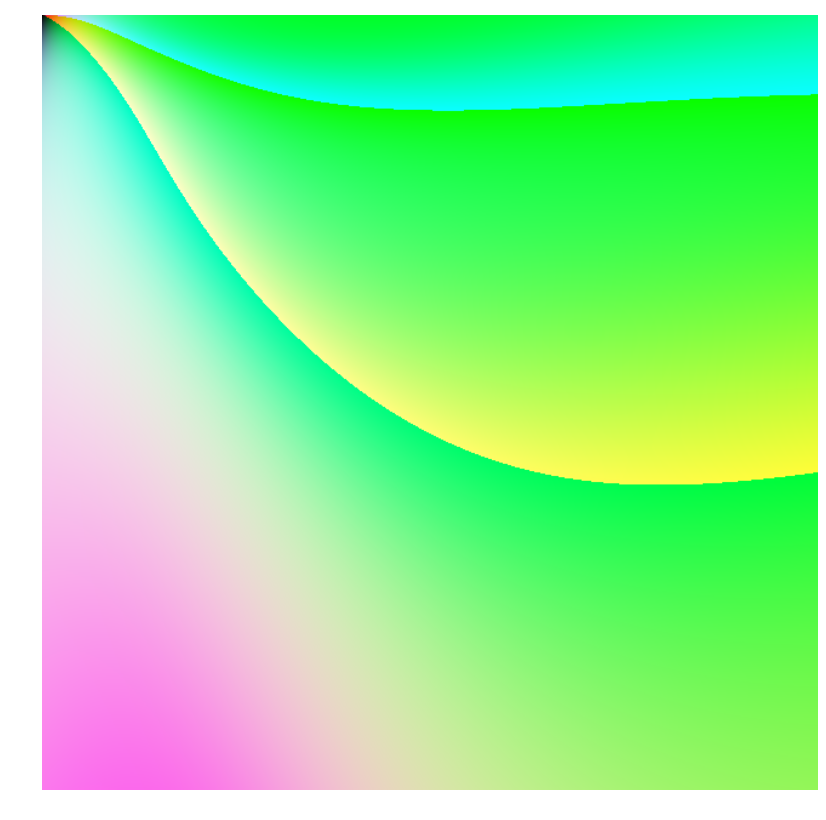

In [5]:
image = generate_image(n_layers=3, n_neurons=10, width=width, height=height, n_out=3) 
show_image(image, bw=False)

Another one with the same parameters?

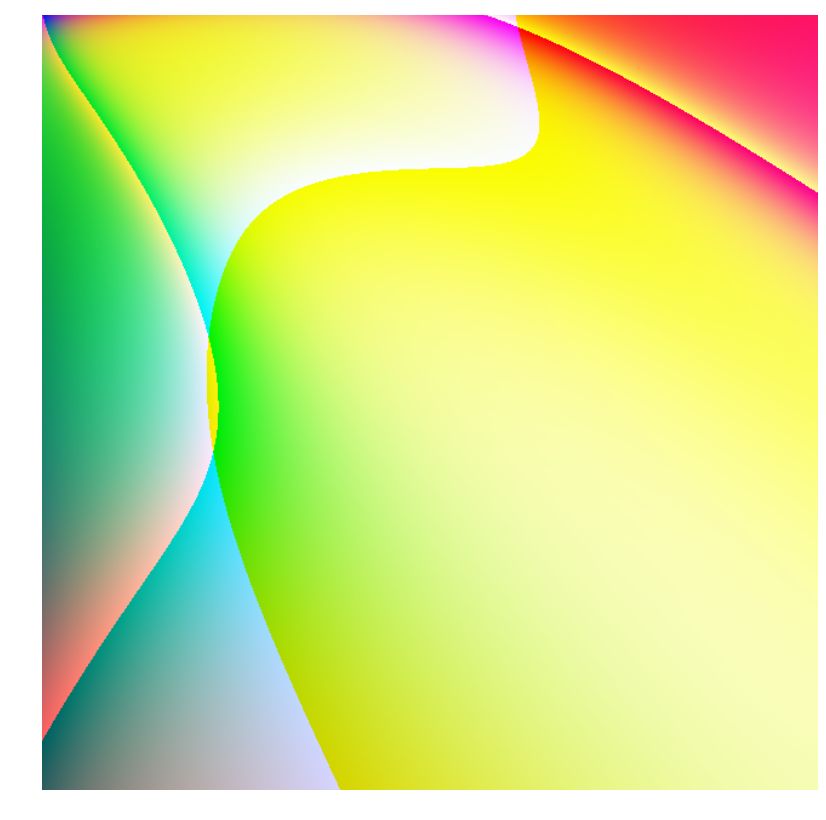

In [6]:
image = generate_image(n_layers=3, n_neurons=10, width=width, height=height, n_out=3) 
show_image(image, bw=False)

Different parameters?

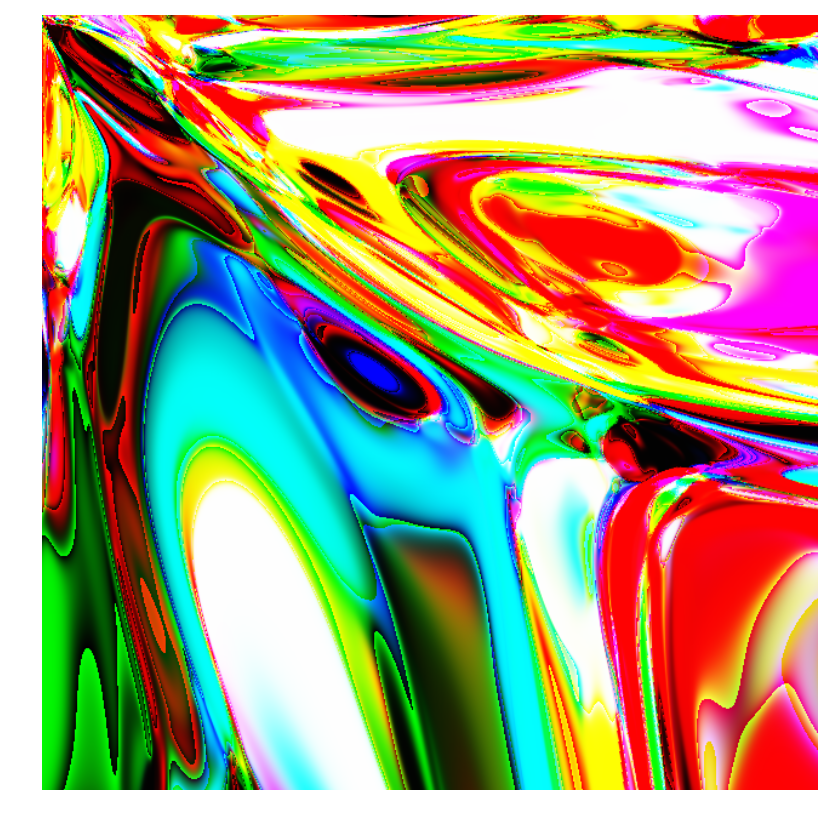

In [11]:
image = generate_image(n_layers=10, n_neurons=30, width=width, height=height, n_out=3) 
show_image(image, bw=False)

## Conclusion

And that's it! Hope this helped, and thank you otoro.net for the great blog posts!

In the original blog post, more improvements were made such that the input also provided a `z` latent vector, and a radius distance for each coordinate. I wanted to keep it as simple as possible, but this may be easily extended:

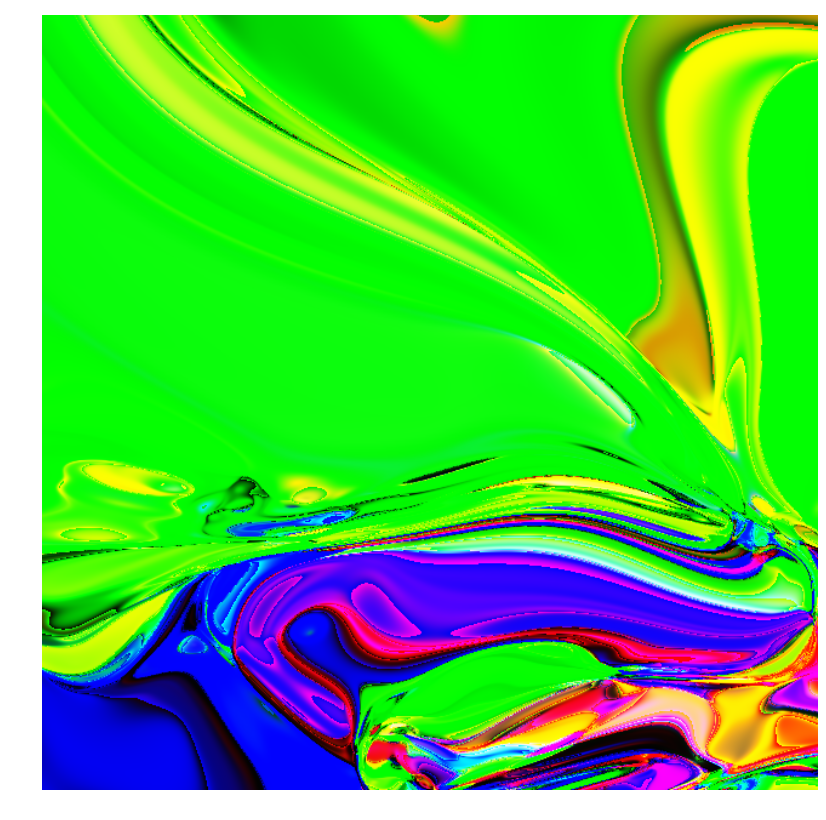

In [10]:
z_dim = 20 # Decide on a dimension for the latent vector

# The inputs will now be the 2 coordinates + dimenions of z + 1 (the radius)
net = Network(n_layers, n_neurons, n_inputs=2 + z_dim + 1, n_outputs=3)
# Generate latent vector from a Gaussian distribution
z = np.random.normal(size=z_dim)

# And just make an image with the same width/height
for i in range(width):
    for j in range(height):
        # This may be anything that provides a distance measure
        r = np.sqrt((width/2 - i)**2 + (height/2 - j)**2)
        # Z is already normalised
        image[i,j] = net.forward_pass([i/width, j/height, r/width, *z])

show_image(image, bw=False)